## 1. Introduction

## 2. First Exploratory Analysis 

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from keras.utils.np_utils import to_categorical 

In [2]:
# read csv files
df_im_train = pd.read_csv('train.csv')
df_im_test = pd.read_csv('test.csv')

# values as numpy arrays
arr_im_train = df_im_train.values
arr_im_test = df_im_test.values

In [3]:
# print shapes
print(arr_im_train.shape)
print(arr_im_test.shape)

(42000, 785)
(28000, 784)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


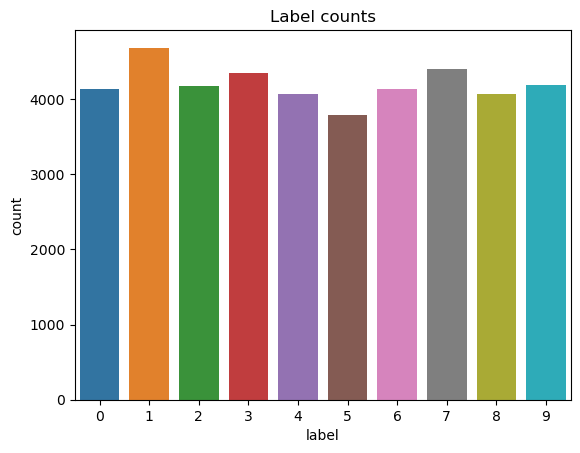

In [4]:
# print value counts for label column
print(df_im_train['label'].value_counts())

# visualize value_counts
sns.countplot(data=df_im_train, x='label')
plt.title('Label counts')
plt.show()

What do we have?
* Each row of the training/test set represents one image, each column one of 784 (28x28) pixel.
* The training set has an additional column (1st column) containing the labels (digits 0-9).
* The labels are relatively evenly distributed, 1 having the highest count (4684) and 5 the lowest (3795).
* Array can be reshaped so that they have the dimensions (m, n_x, n_y, n_z) where m is the number of images and n_x/n_y/n_z the number of pixel in x/y/z-direction.

In [5]:
# shuffle (for the train/dev split which follows)
np.random.shuffle(arr_im_train)

# reshape arrays
Y_train_orig = arr_im_train[:33600,0].reshape(-1,1)
X_train_orig = arr_im_train[:33600,1:]
X_train_orig = X_train_orig.reshape((-1, 28, 28, 1))
Y_dev_orig = arr_im_train[33600:,0].reshape(-1,1)
X_dev_orig = arr_im_train[33600:,1:]
X_dev_orig = X_dev_orig.reshape((-1, 28, 28, 1))
X_test_orig = arr_im_test.reshape((-1, 28, 28, 1))

# one-hot encode and standardize
X_train = X_train_orig/255.
X_dev = X_dev_orig/255.
Y_train = to_categorical(Y_train_orig, num_classes=10)
Y_dev = to_categorical(Y_dev_orig, num_classes=10)

# print shapes
print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)

(33600, 28, 28, 1)
(33600, 10)
(8400, 28, 28, 1)
(8400, 10)


NameError: name 'X_test' is not defined

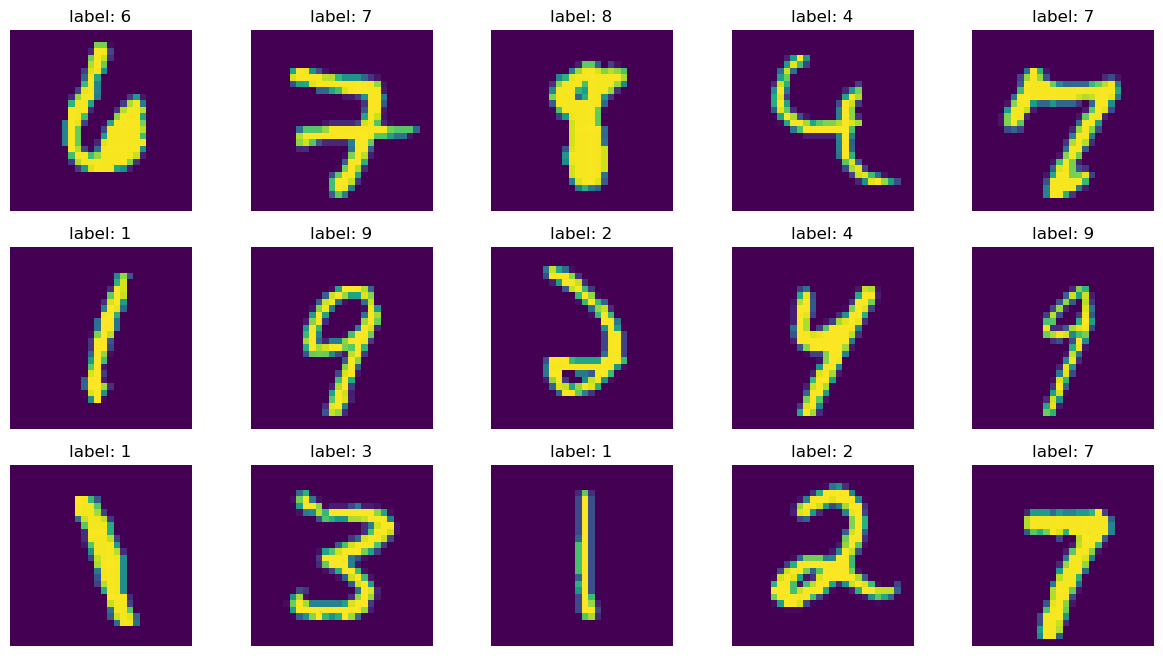

In [11]:
fig, ax = plt.subplots(3, 5, figsize=(15, 8))  
for i in range(len(ax)): 
    for j in range(len(ax[i])):
        no_image = i + j*4
        ax[i,j].imshow(X_train_orig[no_image, :, :, 0])
        ax[i,j].set_title('label: ' + str(Y_train_orig[no_image, 0]))
        ax[i,j].axis('off')
plt.show()

## 3. Building the model

In [78]:
def Model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC -> FC -> SOFTMAX 
    
    Arguments:
    input_shape -- shape of input (n_H, n_W, n_C) (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
        
    # set input
    input_img = tf.keras.Input(shape=input_shape)
    
    # CONV2D: 6 filters 5x5, stride 1, no padding
    Z1 = tfl.Conv2D(6, 5, strides=(1, 1))(input_img)
    
    # RELU
    A1 = tfl.ReLU()(Z1)
    
    # MAXPOOL: window 2x2, stride 2, no padding
    P1 = tfl.MaxPool2D(pool_size=(2, 2), strides=(2,2))(A1)
    
    # CONV2D: 16 filters 5x5, stride 1, no padding
    Z2 = tfl.Conv2D(16,5,strides=(1, 1))(P1)
    
    # RELU
    A2 = tfl.ReLU()(Z2)
    
    # MAXPOOL: window 2x2, stride 2, no padding
    P2 = tfl.MaxPool2D(pool_size=(2, 2), strides=(2,2))(A2)
    
    # FLATTEN
    F = tfl.Flatten()(P2)
    
    # 1st FC layer: 120 neurons
    FC1 = tfl.Dense(120, activation='relu')(F) 
    
    # 1st FC layer: 84 neurons
    FC2 = tfl.Dense(84, activation='softmax')(FC1) 
    
    # Dense layer
    outputs = tfl.Dense(10, activation='softmax')(FC2) 
    
    # create model
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    
    return model

In [79]:
# instantiate model
model = Model((28,28,1))

# compile and print summary
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 re_lu_12 (ReLU)             (None, 24, 24, 6)         0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 re_lu_13 (ReLU)             (None, 8, 8, 16)          0         
                                                           

In [80]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_dev, Y_dev)).batch(64)
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
525/525 [==============================] - 30s 55ms/step - loss: 1.8745 - accuracy: 0.5334 - val_loss: 1.5542 - val_accuracy: 0.5871
Epoch 2/30
525/525 [==============================] - 26s 49ms/step - loss: 1.3345 - accuracy: 0.5945 - val_loss: 1.1525 - val_accuracy: 0.5940
Epoch 3/30
525/525 [==============================] - 25s 48ms/step - loss: 1.0403 - accuracy: 0.5989 - val_loss: 0.9617 - val_accuracy: 0.5931
Epoch 4/30
525/525 [==============================] - 26s 49ms/step - loss: 0.8858 - accuracy: 0.6037 - val_loss: 0.8512 - val_accuracy: 0.5996
Epoch 5/30
525/525 [==============================] - 28s 52ms/step - loss: 0.7980 - accuracy: 0.6068 - val_loss: 0.7922 - val_accuracy: 0.6007
Epoch 6/30
525/525 [==============================] - 26s 49ms/step - loss: 0.7456 - accuracy: 0.6053 - val_loss: 0.7446 - val_accuracy: 0.6064
Epoch 7/30
525/525 [==============================] - 41s 79ms/step - loss: 0.7110 - accuracy: 0.6073 - val_loss: 0.7198 - val_accuracy:

C:\Users\ugrasju\AppData\Local\Temp\ipykernel_12052\973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\ugrasju\AppData\Local\Temp\ipykernel_12052\973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

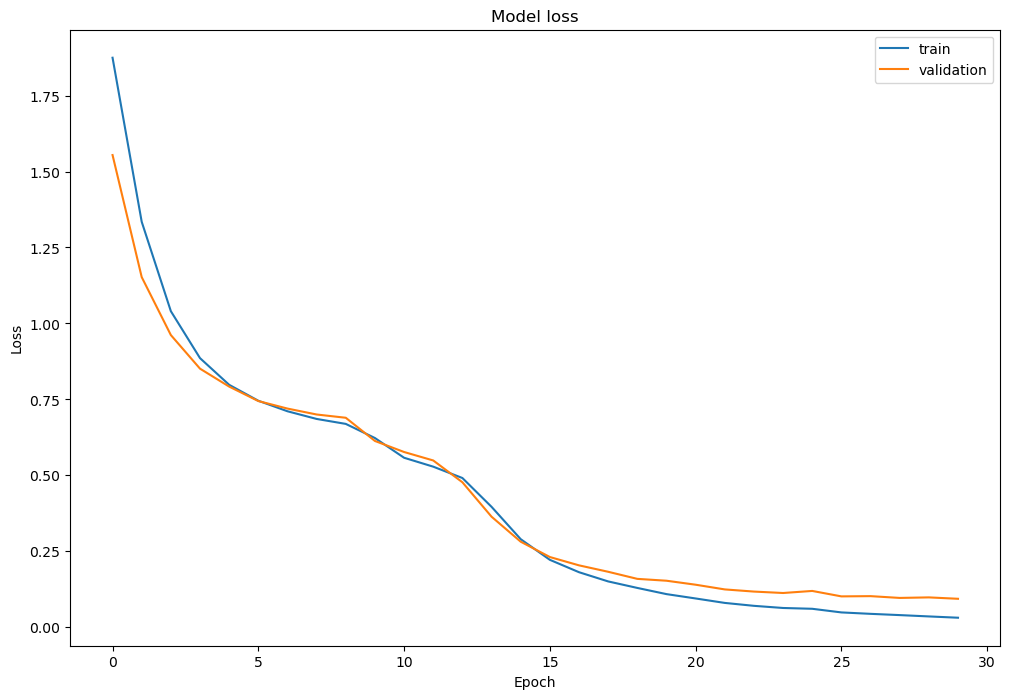

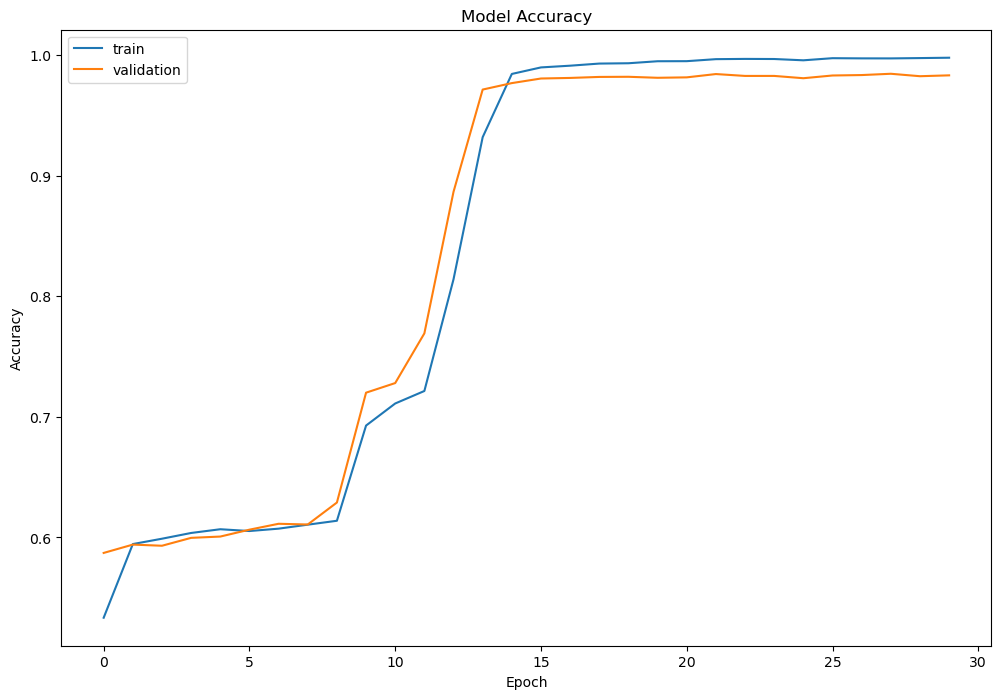

In [81]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')